In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

from qiskit.visualization import *

# custom utility functions
from util import *
from qetu import *
from tfim import *
from fermi_hubbard import *

### Test TFIM Implementation

In [2]:
delta_t = 0.00012345
tfim = TFIM(4, 1.43535)
H = tfim.Hamiltonian
U = expm(-1j*delta_t*H)

qc = tfim.Trotterization(delta_t, 100)
trotter = get_matrix(qc)

print("second order Trotter error {:.5e}".format(np.linalg.norm(U - trotter, 2)))

ctrl_U = scipy.linalg.block_diag(U.conjugate().transpose(), U)
ctrl_free_qc = tfim.Control_free_Trotter(2)
ctrl_free_trotter = get_matrix(ctrl_free_qc)

print("controlled Trotter error {:.5e}".format(np.linalg.norm(ctrl_U - ctrl_free_trotter, 2)))

second order Trotter error 7.73817e-06
controlled Trotter error 1.99522e+00


### Test Fermi Hubbard Implementation

In [3]:
delta_t = 0.00012345
fh = FermiHubbard(2, 0.5, 6, 1)
H = fh.Hamiltonian
U = expm(-1j*delta_t*H)

qc = fh.Trotterization(delta_t, 100)
trotter = get_matrix(qc)

print("second order Trotter error {:.5e}".format(np.linalg.norm(U - trotter, 2)))

ctrl_U = scipy.linalg.block_diag(U.conjugate().transpose(), U)
ctrl_free_qc = fh.Trotterization(delta_t, 100, True)
ctrl_free_trotter = get_matrix(ctrl_free_qc)

print("controlled Trotter error {:.5e}".format(np.linalg.norm(ctrl_U - ctrl_free_trotter, 2)))

second order Trotter error 9.87600e-04
controlled Trotter error 1.05785e-03


### Test QSP Implementation

In [4]:
step_function_qsp_angles = [
     0.7854,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
    -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
     0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
    -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
    -0.0000, -0.0000,  0.0001, -0.0001, -0.0000,  0.0001, -0.0001, -0.0000,
     0.0001, -0.0001, -0.0000,  0.0002, -0.0002, -0.0000,  0.0002, -0.0002,
    -0.0000,  0.0003, -0.0003, -0.0000,  0.0004, -0.0004, -0.0000,  0.0005,
    -0.0005, -0.0001,  0.0007, -0.0006, -0.0001,  0.0008, -0.0008, -0.0001,
     0.0011, -0.0010, -0.0001,  0.0013, -0.0013, -0.0001,  0.0016, -0.0016,
    -0.0002,  0.0020, -0.0020, -0.0002,  0.0025, -0.0024, -0.0003,  0.0030,
    -0.0029, -0.0003,  0.0036, -0.0035, -0.0004,  0.0044, -0.0042, -0.0005,
     0.0053, -0.0050, -0.0007,  0.0063, -0.0059, -0.0009,  0.0076, -0.0070,
    -0.0011,  0.0091, -0.0083, -0.0014,  0.0109, -0.0099, -0.0019,  0.0132,
    -0.0119, -0.0025,  0.0163, -0.0144, -0.0035,  0.0204, -0.0176, -0.0051,
     0.0262, -0.0221, -0.0079,  0.0355, -0.0287, -0.0137,  0.0525, -0.0400,
    -0.0288,  0.0938, -0.0648, -0.1037,  0.3454, -0.4677,  0.3454, -0.1037,
    -0.0648,  0.0938, -0.0288, -0.0400,  0.0525, -0.0137, -0.0287,  0.0355,
    -0.0079, -0.0221,  0.0262, -0.0051, -0.0176,  0.0204, -0.0035, -0.0144,
     0.0163, -0.0025, -0.0119,  0.0132, -0.0019, -0.0099,  0.0109, -0.0014,
    -0.0083,  0.0091, -0.0011, -0.0070,  0.0076, -0.0009, -0.0059,  0.0063,
    -0.0007, -0.0050,  0.0053, -0.0005, -0.0042,  0.0044, -0.0004, -0.0035,
     0.0036, -0.0003, -0.0029,  0.0030, -0.0003, -0.0024,  0.0025, -0.0002,
    -0.0020,  0.0020, -0.0002, -0.0016,  0.0016, -0.0001, -0.0013,  0.0013,
    -0.0001, -0.0010,  0.0011, -0.0001, -0.0008,  0.0008, -0.0001, -0.0006,
     0.0007, -0.0001, -0.0005,  0.0005, -0.0000, -0.0004,  0.0004, -0.0000,
    -0.0003,  0.0003, -0.0000, -0.0002,  0.0002, -0.0000, -0.0002,  0.0002,
    -0.0000, -0.0001,  0.0001, -0.0000, -0.0001,  0.0001, -0.0000, -0.0001,
     0.0001, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
    -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
    -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
     0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
    -0.0000,  0.0000,  0.7854]

C:\Users\thilo\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


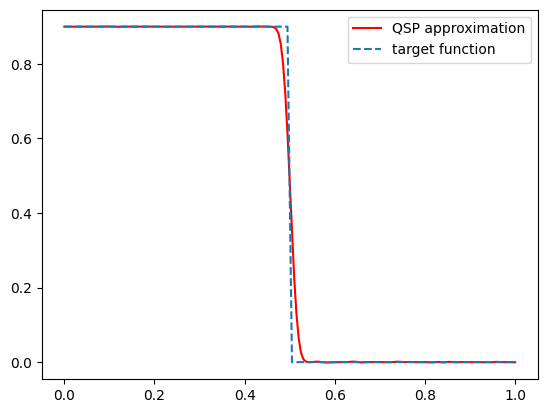

In [5]:
def target_heaviside(x, scale=1):
    """
        Target function for eigenvalue filtering.
    """
    return scale * np.heaviside(-x+0.5, 0.5)

x_vec = np.linspace(0, 1, 201)
y_vec = []
for x in x_vec:
    qsp_circuit = QSP(step_function_qsp_angles, x)
    y = get_matrix(qsp_circuit)[0,0]
    y_vec.append(y)

plt.plot(x_vec, y_vec, "r", label="QSP approximation")
plt.plot(x_vec, target_heaviside(x_vec, scale=0.9), "--", label="target function")
plt.legend()

### Test QETU Implementation

In [6]:
H = np.diag(np.array([2*np.arccos(0.1), 2*np.arccos(0.3), 2*np.arccos(0.6), 2*np.arccos(0.9)]))
array_to_latex(H)

<IPython.core.display.Latex object>

expected eigenvalues: [0. 0. 1. 1.]
actual eigenvalues: [0.4650173  0.46537306 1.33545046 1.33557438]


Text(0, 0.5, 'U = F(cos(λ/2))')

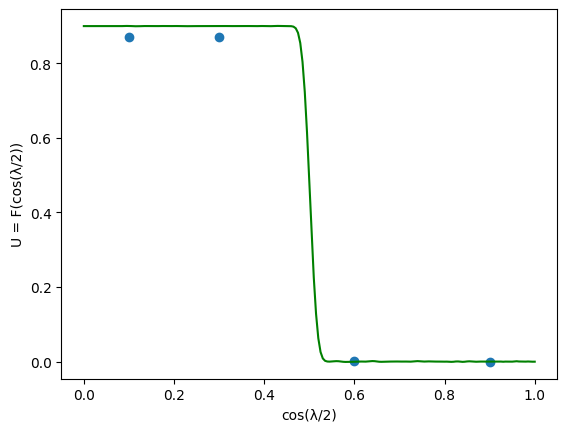

In [7]:
from qiskit.extensions import UnitaryGate

V = UnitaryGate(expm(-1j*H), label="$e^{-iH}$").control(1, ctrl_state='1')
q = QuantumRegister(3, 'q')
V_qc = QuantumCircuit(q)
V_qc.append(V, q)

U_qc = get_matrix(QETU(V_qc, convert_SU2_to_Xrot(step_function_qsp_angles)))[0:4,0:4]
λ, v = np.linalg.eigh(H)
print("expected eigenvalues: " + str(target_heaviside(np.cos(λ/2))))
F_λ, F_v = np.linalg.eigh(U_qc)
print("actual eigenvalues: " + str(F_λ))

x_list = np.linspace(0, 1, 201)
QSP_list = []
for x in x_list:
    QSP_circuit = QSP(step_function_qsp_angles, x)
    result = get_matrix(QSP_circuit)[0,0]
    QSP_list.append(result)

#plt.plot(x_list, target_filt(x_list, scale=0.9), "--", label="target function")
plt.plot(x_list, QSP_list, "g", label="Re[Poly(a)]")
plt.scatter(x=np.cos(λ/2), y=F_λ-0.4650173)
plt.xlabel("cos(λ/2)")
plt.ylabel("U = F(cos(λ/2))")

### Test QETU Ground State Estimation

In [8]:
delta_t = 0.00012345
fh = FermiHubbard(2, 2.343, 3.4534, 9.343)
H = fh.Hamiltonian
U = expm(-1j*delta_t*H)

# Diagonalize the Hamiltonian
λ, v = np.linalg.eigh(H)
# Find the ground state
ground_state_index = np.argmin(λ)
ground_state_energy = λ[ground_state_index]
ground_state_vector = v[:, ground_state_index]

print("Ground state energy:", ground_state_energy)
print("Ground state vector:", ground_state_vector)

Ground state energy: -74.76394203685358
Ground state vector: [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j  4.94192433e-01+0.j
  5.05740882e-01+0.j -1.11022302e-16+0.j  0.00000000e+00+0.j
  5.05740882e-01+0.j  4.94192433e-01+0.j -8.86827467e-17+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j]


In [9]:
V = fh.Trotterization(delta_t, 100, True)
qetu_cirtuit = QETU(V, step_function_qsp_angles)
